In [1]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2024-06-06 17:53:46.630879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 17:53:47.536617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64${LD_LIBRARY_PATH:+:}
2024-06-06 17:53:47.536800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64${LD_LIBRARY_PATH:+:}
2024-06-06 17:53:47.536812

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU') # 실행하여 GPU가 인식된다면, 자동으로 GPU 연산 가능

2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
df = pd.read_csv('/home/miserver10/workspace_vscode/datasets/Taxi_Traffic.csv', index_col= 0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 241.9+ KB


In [5]:
# Converting to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
# Setting a datetime index to the dataframe
df = df.set_index('timestamp')

In [7]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


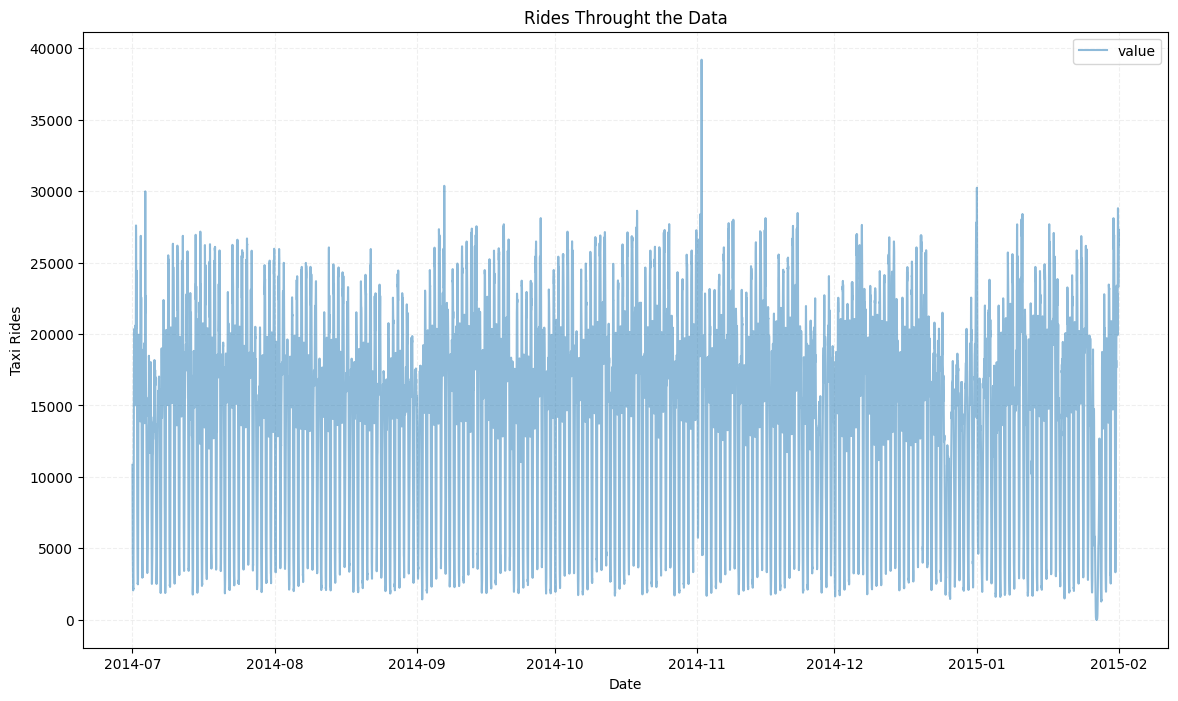

In [8]:
# 시각화
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['value'], label='value', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Taxi Rides')
plt.title('Rides Throught the Data')
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend()
plt.show()

In [9]:
df[df['value'] > 35000]

,value
timestamp,
2014-11-02 01:00:00,39197
2014-11-02 01:30:00,35212


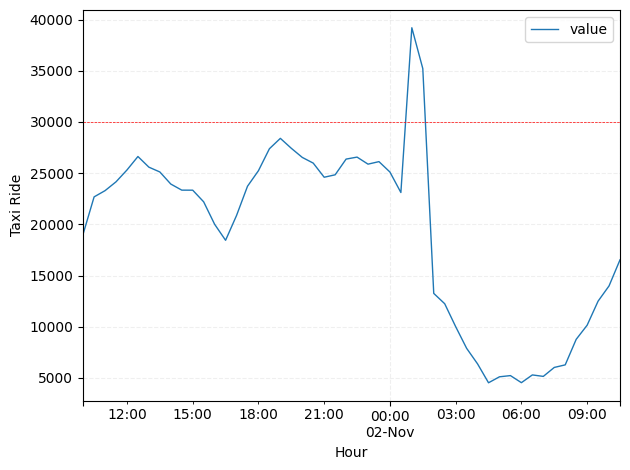

In [10]:
# Taking a closure look at the data

df.loc['2014-11-01 10:00:00':,].head(50).plot(linewidth = 1)

plt.xlabel('Hour')
plt.ylabel('Taxi Ride')
plt.axhline(y = 30000, color = 'red', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.grid(linestyle = '--', alpha = 0.2)
plt.show()

In [11]:
# Capping these outlier to 20000 (결측치 제거)
df[df['value'] > 35000] = 20000

In [12]:
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df.head()

,value,day,hour,weekday,month
timestamp,,,,,
2014-07-01 00:00:00,10844,1,0,1,7
2014-07-01 00:30:00,8127,1,0,1,7
2014-07-01 01:00:00,6210,1,1,1,7
2014-07-01 01:30:00,4656,1,1,1,7
2014-07-01 02:00:00,3820,1,2,1,7


In [13]:
downsampled_df = df.resample('D').mean()

In [14]:
downsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2014-07-01 to 2015-01-31
Freq: D
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   value    215 non-null    float64
 1   day      215 non-null    float64
 2   hour     215 non-null    float64
 3   weekday  215 non-null    float64
 4   month    215 non-null    float64
dtypes: float64(5)
memory usage: 10.1 KB


In [15]:
downsampled_df.head()

,value,day,hour,weekday,month
timestamp,,,,,
2014-07-01,15540.979167,1.0,11.5,1.0,7.0
2014-07-02,15284.166667,2.0,11.5,2.0,7.0
2014-07-03,14794.625000,3.0,11.5,3.0,7.0
2014-07-04,11511.770833,4.0,11.5,4.0,7.0
2014-07-05,11572.291667,5.0,11.5,5.0,7.0


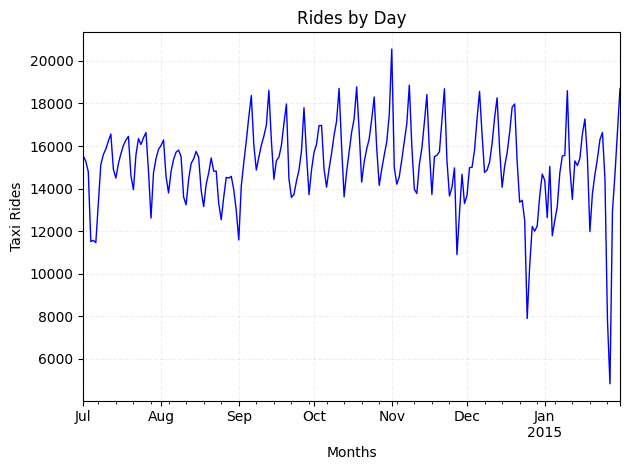

In [16]:
df_day = df['value'].resample('D').mean()
df_day.plot(linewidth = 1, color = 'blue')
plt.xlabel("Months")
plt.ylabel("Taxi Rides")
plt.title("Rides by Day")
plt.tight_layout()
plt.grid(linestyle = '--', alpha = 0.2)
plt.show()

In [17]:
downsampled_df = downsampled_df[['value']]

In [18]:
downsampled_df.head()

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667


In [19]:
# 데이터 전처리
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(downsampled_df[['value']])

# 데이터 분할 (훈련과 테스트)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [20]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length, 0]
        label = data[i + sequence_length, 0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 10   # 하루 단위로 예측
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [21]:
# 데이터를 3D 형태로 변환 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) 

In [22]:
X_train.shape

(162, 10, 1)

In [23]:
# RNN 모델 구성
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=False, activation='relu'))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, batch_size=1, epochs=30)

2024-06-06 17:53:49.820308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 17:53:51.253836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5
2024-06-06 17:53:51.254702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10009 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1


Epoch 1/30


2024-06-06 17:53:54.172703: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fde6c00f020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 17:53:54.172743: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-06-06 17:53:54.172753: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-06 17:53:54.185771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 17:53:54.341937: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 [==============================] - 9s 30ms/step - loss: 0.0382
Epoch 2/30
162/162 [==============================] - 5s 30ms/step - loss: 0.0106
Epoch 3/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0099
Epoch 4/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0103
Epoch 5/30
162/162 [==============================] - 5s 28ms/step - loss: 0.0104
Epoch 6/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0102
Epoch 7/30
162/162 [==============================] - 5s 30ms/step - loss: 0.0102
Epoch 8/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0102
Epoch 9/30
162/162 [==============================] - 5s 30ms/step - loss: 0.0100
Epoch 10/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0097
Epoch 11/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0098
Epoch 12/30
162/162 [==============================] - 5s 29ms/step - loss: 0.0096
Epoch 13/30
162/162 [===

In [24]:
# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

2/2 [==============================] - 0s 14ms/step - loss: 0.0327
Mean Squared Error: 0.03272885084152222


2/2 [==============================] - 0s 12ms/step


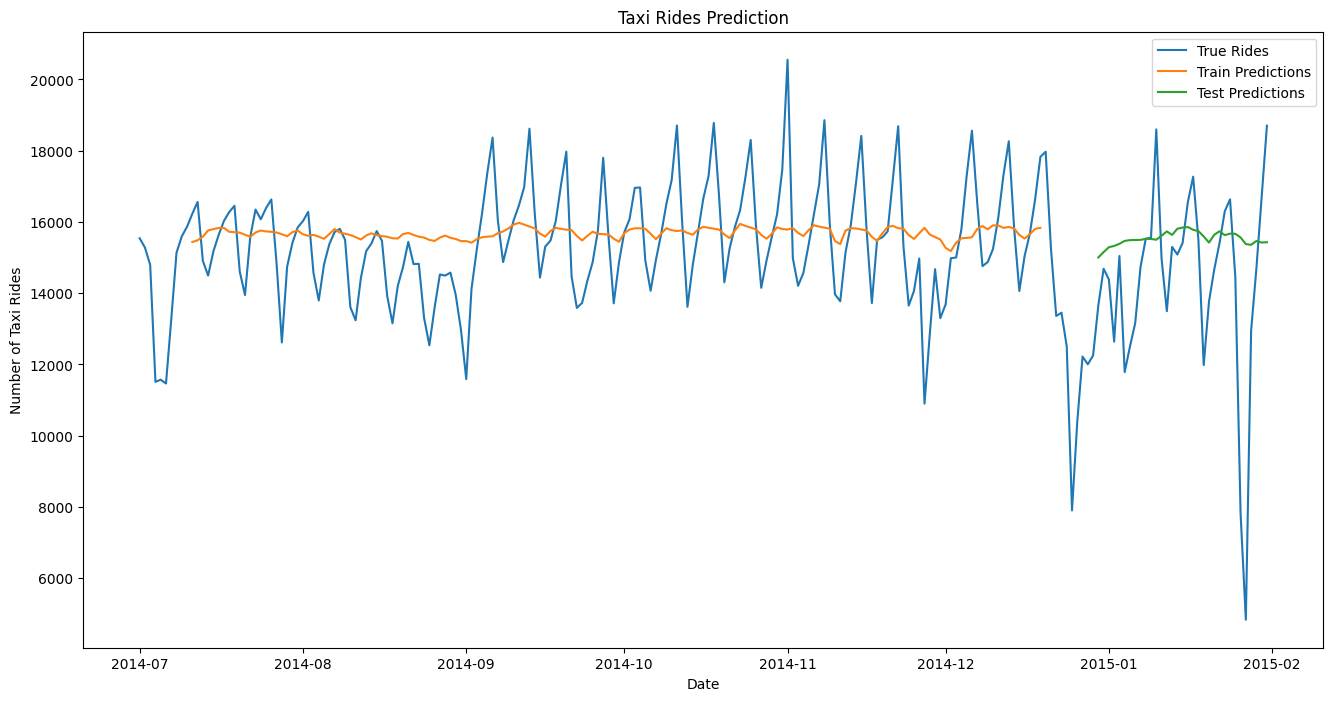

In [25]:
# 예측 수행
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# 원래 스케일로 변환
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 빈 배열 생성
train_predictions_plot = np.empty((len(downsampled_df), 1))
train_predictions_plot[:, :] = np.nan
test_predictions_plot = np.empty((len(downsampled_df), 1))
test_predictions_plot[:, :] = np.nan

# 예측값 할당
train_predictions_plot[sequence_length:len(train_predictions) + sequence_length, 0] = train_predictions[:, 0]
test_predictions_plot[sequence_length + len(train_predictions) + sequence_length:len(downsampled_df) , 0] = test_predictions[:, 0]

# 데이터프레임에 예측값 추가
downsampled_df['Train Predictions'] = train_predictions_plot
downsampled_df['Test Predictions'] = test_predictions_plot

# 시각화
plt.figure(figsize=(16, 8))
plt.title('Taxi Rides Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Taxi Rides')
plt.plot(downsampled_df.index, downsampled_df['value'], label='True Rides')
plt.plot(downsampled_df.index, downsampled_df['Train Predictions'], label='Train Predictions')
plt.plot(downsampled_df.index, downsampled_df['Test Predictions'], label='Test Predictions')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE 계산
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error (MSE): {mse}')

# MAE 계산
mae = mean_absolute_error(y_test, test_predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 8086829.863083844
Mean Absolute Error (MAE): 1845.541982323233
